In [1]:
from collections import Counter
from zensvi.cv import Segmenter
from tqdm.notebook import tqdm
from skimage import measure
from PIL import Image
from zensvi.cv import DepthEstimator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <BFAC0362-079C-3D60-A731-79532A75BA60> /Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mquintana/miniforge3/envs/greenery/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can igno

Weights file already exists.


/Users/mquintana/miniforge3/envs/greenery/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# run this on server
# segmenter = Segmenter(dataset="mapillary", task="panoptic", device="cpu")
# segmenter.segment(
#     "data/svi/all",
#     dir_image_output="data/segmented_panoptic",
#     dir_summary_output="data/segmented_panoptic",
#     batch_size=1
# )
# del segmenter


# Utility functions

In [2]:
def process_segmentation(image_path, tolerance=3):
    # read image
    img = cv2.imread(image_path)

    # check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image at path: {image_path}")
    
    # OpenCV loads in BGR, convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # greenery colors based on Mapillary Vistas
    vegetation_color = np.array([107, 142, 35])  # Olive green
    terrain_color = np.array([153, 250, 152])    # Light green)

    # create masks for each color with tolerance
    def create_color_mask(image, color, tolerance=3):
        # Create lower and upper bounds
        lower_bound = np.clip(color - tolerance, 0, 255)
        upper_bound = np.clip(color + tolerance, 0, 255)
        
        # Create mask using cv2.inRange
        mask = cv2.inRange(image, lower_bound, upper_bound)
        return mask

    # create individual masks
    vegetation_mask = create_color_mask(img, vegetation_color, tolerance)
    terrain_mask = create_color_mask(img, terrain_color, tolerance)

    # combine masks
    combined_mask = cv2.bitwise_or(vegetation_mask, terrain_mask)

    # compute GVI
    total_pixels = img.shape[0] * img.shape[1]
    green_pixels = np.count_nonzero(combined_mask)
    gvi = green_pixels / total_pixels

    return combined_mask, gvi

In [4]:
def process_segmentation_2(image_path):
    # OLD CODE: It does not take into account green terrain
    # Read image
    img = cv2.imread(image_path)
    
    # Check if image was loaded successfully
    if img is None:
        raise ValueError(f"Failed to load image at path: {image_path}")
    
    # OpenCV loads in BGR, convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create binary mask for vegetation (assuming green segmentation)
    vegetation_color = np.array([107, 142, 35])  # RGB olive green
    mask = np.all(img == vegetation_color, axis=2).astype(np.uint8)

    return mask

In [ ]:
def get_window_sizes(mask, list_windows, relative_window_size=0.25):
    """
    """
    # Ensure mask is float32 for better precision with OpenCV
    mask = mask.astype(np.float32)
    
    # Get image dimensions
    height, width = mask.shape
    
    # Calculate window size as a fraction of the smaller dimension
    window_size = int(min(height, width) * relative_window_size)
    
    # Ensure window size is at least 4 pixels
    window_size = max(4, window_size)

    list_windows.append(window_size)

    # Return average entropy
    return list_windows

0.15935802459716797
501297


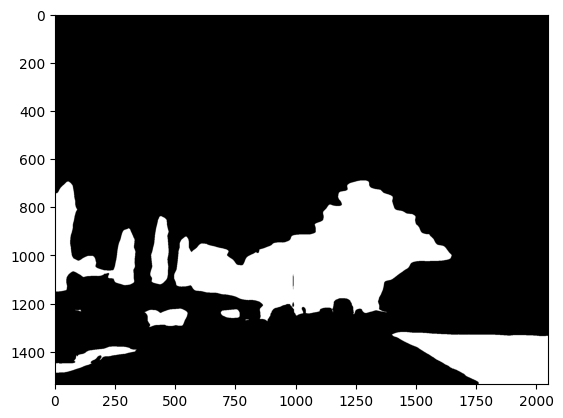

In [5]:
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/c0764cb5-f2fd-40cb-9aed-3eff846675ef_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/38ba29ee-7e23-4ad8-addc-0f90afc7c38e_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/cf55f412-6375-4e27-86f2-2f3789a09a5f_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/76d51909-0a1e-4a6b-b0bc-ef9e5d1781ab_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/ebe4b60d-113d-45a8-a623-ac150f3df170_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/c761deb5-0da8-4b08-9726-d301143d378f_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/00a0bc44-f0eb-4762-ac67-0d7823d087c4_colored_segmented.png")
#test_img, test_gvi = process_segmentation("data/segmented_panoptic/3a3eeda9-aa6c-4666-9144-f07d0680aab8_colored_segmented.png")
test_img, test_gvi = process_segmentation("data/segmented_panoptic/caf0a475-6738-4041-b469-b720ae22cc3b_colored_segmented.png")
#test_img, test_gvi = process_segmentation_figure("img/ChatGPT_2.png", 50)
plt.imshow(test_img, cmap='gray')
print(test_gvi)
print(np.sum(test_img == 255)) # count num of mask's pixels 

# save image
img = Image.fromarray(test_img)
img.save("test_gvi.png")

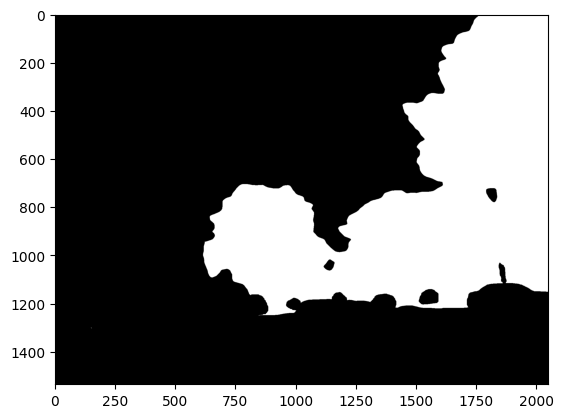

In [6]:
#test_img = process_segmentation_2("data/segmented_panoptic/c0764cb5-f2fd-40cb-9aed-3eff846675ef_colored_segmented.png")
#test_img = process_segmentation_2("data/segmented_panoptic/38ba29ee-7e23-4ad8-addc-0f90afc7c38e_colored_segmented.png")
test_img = process_segmentation_2("data/segmented_panoptic/cf55f412-6375-4e27-86f2-2f3789a09a5f_colored_segmented.png")
plt.imshow(test_img, cmap='gray')

# Process mask, GVI, and range of window sizes 

In [ ]:
data_folder = "data/segmented_panoptic/"
all_files = os.listdir(data_folder)
segmented_string = "_colored_segmented.png"
segmented_files = [f for f in all_files if segmented_string in f]

df_all_gvi = pd.DataFrame(columns=["uuid", "green_view_index"])
list_windows = []

# takes some time to run on CPU
for file_name in tqdm(segmented_files, desc="Processing images"):
    # compute mask
    mask, gvi = process_segmentation(data_folder + file_name)

    # compute entropy metrics
    list_windows = get_window_sizes(mask, list_windows, 0.45)

    # keep track of uuid (file_name) and their gvi 
    df_all_gvi.loc[len(df_all_gvi)] = {
        "uuid": file_name.replace(segmented_string, ""),
        "green_view_index": gvi
    } 
    # end for loop

# save the file
df_all_gvi.to_csv("data/labels/processed/all_imgs_gvi.csv", index=False)


In [ ]:
min(list_windows)

In [ ]:
max(list_windows)